In [1]:
import pandas as pd
import numpy as np
from importlib import reload
import torch
from torch import nn
%load_ext line_profiler
pd.options.display.max_columns = 100

## Download data

In [2]:
import sys
import os

sys.path.append(os.path.abspath('../..'))

In [3]:
data_root = os.path.abspath('../../_data/kaggle/rossman')
#!kaggle competitions download -c rossmann-store-sales -p $data_root

In [6]:
import urllib.request
import os

os.makedirs(data_root, exist_ok=True)
urllib.request.urlretrieve('http://files.fast.ai/part2/lesson14/rossmann.tgz', os.path.join(data_root, 'rossmann.tgz'))

('D:\\learn\\online_course\\notes\\_data\\kaggle\\rossman\\rossmann.tgz',
 <http.client.HTTPMessage at 0x16c094219b0>)

In [4]:
from glob import glob
import shutil
#for zipfile in glob(data_root + '/*.(zip)|(tgz)'):
for zipfile in glob(data_root + '/*.tgz'):
    shutil.unpack_archive(zipfile, data_root)

In [5]:
ls $data_root

 Volume in drive D is Work
 Volume Serial Number is 08AF-55F7

 Directory of D:\learn\online_course\notes\_data\kaggle\rossman

07/11/2018  12:48 PM    <DIR>          .
07/11/2018  12:48 PM    <DIR>          ..
01/11/2017  12:16 PM            86,605 googletrend.csv
07/13/2018  02:24 PM         7,730,448 rossmann.tgz
09/30/2015  06:48 AM           317,611 sample_submission.csv
01/11/2017  09:19 AM               265 state_names.csv
09/30/2015  06:48 AM            45,010 store.csv
01/07/2017  06:17 AM             9,051 store_states.csv
09/30/2015  06:48 AM         1,427,425 test.csv
09/30/2015  06:48 AM        38,057,952 train.csv
01/11/2017  12:13 PM         1,518,814 weather.csv
               9 File(s)     49,193,181 bytes
               2 Dir(s)  184,083,996,672 bytes free


## Preprocessing

In [4]:
import pandas as pd
from pandas_summary import DataFrameSummary
from IPython.display import display
from glob import glob

In [5]:
table_names = [os.path.splitext(os.path.basename(f))[0] for f in glob(data_root + '/*.csv')]
tables = [pd.read_csv(f, low_memory=False) for f in glob(data_root + '/*.csv')]
print(', '.join(table_names))

googletrend, sample_submission, state_names, store, store_states, test, train, weather


In [7]:
for name, tb in zip(table_names, tables):
    print(name)
    display(tb.head())

googletrend


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


sample_submission


,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


state_names


,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


store


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


store_states


,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


test


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


train


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


weather


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


In [9]:
for tb in tables:
    display(DataFrameSummary(tb).summary())

D:\dev\libs\Anaconda3\envs\tf140p35\lib\site-packages\pandas_summary\__init__.py:86: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat([counts, uniques, missing], axis=1)
D:\dev\libs\Anaconda3\envs\tf140p35\lib\site-packages\pandas_summary\__init__.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([self.df.describe(), self.columns_stats])[self.df.columns]


,file,week,trend
count,NaN,NaN,2072
mean,NaN,NaN,63.8142
std,NaN,NaN,12.6502
min,NaN,NaN,0
25%,NaN,NaN,55
50%,NaN,NaN,64
75%,NaN,NaN,72
max,NaN,NaN,100
counts,2072,2072,2072
uniques,14,148,68


,Id,Sales
count,41088,41088
mean,20544.5,0
std,11861.2,0
min,1,0
25%,10272.8,0
50%,20544.5,0
75%,30816.2,0
max,41088,0
counts,41088,41088
uniques,41088,1


,StateName,State
count,16,16
unique,16,16
top,Niedersachsen,MV
freq,1,1
counts,16,16
uniques,16,16
missing,0,0
missing_perc,0%,0%
types,unique,unique


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115,NaN,NaN,1112,761,761,1115,571,571,NaN
mean,558,NaN,NaN,5404.9,7.2247,2008.67,0.512108,23.5954,2011.76,NaN
std,322.017,NaN,NaN,7663.17,3.21235,6.19598,0.500078,14.142,1.67494,NaN
min,1,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,279.5,NaN,NaN,717.5,4,2006,0,13,2011,NaN
50%,558,NaN,NaN,2325,8,2010,1,22,2012,NaN
75%,836.5,NaN,NaN,6882.5,10,2013,1,37,2013,NaN
max,1115,NaN,NaN,75860,12,2015,1,50,2015,NaN
counts,1115,1115,1115,1112,761,761,1115,571,571,571
uniques,1115,4,3,654,12,23,2,24,7,3


,Store,State
count,1115,NaN
mean,558,NaN
std,322.017,NaN
min,1,NaN
25%,279.5,NaN
50%,558,NaN
75%,836.5,NaN
max,1115,NaN
counts,1115,1115
uniques,1115,12


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088,41088,41088,NaN,41077,41088,NaN,41088
mean,20544.5,555.9,3.97917,NaN,0.854322,0.395833,NaN,0.443487
std,11861.2,320.274,2.01548,NaN,0.352787,0.489035,NaN,0.496802
min,1,1,1,NaN,0,0,NaN,0
25%,10272.8,279.75,2,NaN,1,0,NaN,0
50%,20544.5,553.5,4,NaN,1,0,NaN,0
75%,30816.2,832.25,6,NaN,1,1,NaN,1
max,41088,1115,7,NaN,1,1,NaN,1
counts,41088,41088,41088,41088,41077,41088,41088,41088
uniques,41088,856,7,48,2,2,2,2


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056
min,1,1,NaN,0,0,0,0,NaN,0
25%,280,2,NaN,3727,405,1,0,NaN,0
50%,558,4,NaN,5744,609,1,0,NaN,0
75%,838,6,NaN,7856,837,1,1,NaN,0
max,1115,7,NaN,41551,7388,1,1,NaN,1
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
count,NaN,NaN,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,15459,15459,15459,15840,15840,3604,15840,14667,NaN,15840
mean,NaN,NaN,14.6441,10.389,6.19899,8.58782,6.20581,3.62614,93.6596,74.2829,50.1586,1018.53,1015.3,1012.31,24.0576,12.2398,7.02516,22.7666,11.9722,48.8643,0.831718,5.55131,NaN,175.897
std,NaN,NaN,8.64601,7.37926,6.52639,6.24478,6.08677,6.12839,7.67853,13.4866,19.9602,7.78872,8.12331,8.60058,8.9768,5.06794,4.9806,8.98862,5.87284,13.027,2.51351,1.68771,NaN,101.589
min,NaN,NaN,-11,-13,-15,-14,-15,-73,44,30,4,976,974,970,0,0,0,3,2,21,0,0,NaN,-1
25%,NaN,NaN,8,4,1,4,2,-1,90.75,65,34,1014,1010,1007,14,10,3,16,8,39,0,5,NaN,80
50%,NaN,NaN,15,11,7,9,7,4,94,76,49,1019,1016,1013,31,11,7,21,11,48,0,6,NaN,202
75%,NaN,NaN,21,16,11,13,11,8,100,85,66,1024,1021,1018,31,14,10,27,14,55,0.25,7,NaN,256
max,NaN,NaN,39,31,24,25,20,19,100,100,100,1043,1040,1038,31,31,31,101,53,111,58.93,8,NaN,360
counts,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,15459,15459,15459,15840,15840,3604,15840,14667,11889,15840
uniques,16,990,51,45,40,40,36,40,53,71,93,67,67,69,24,32,24,44,29,47,41,9,21,362


In [6]:
googletrend, sample_submission, state_names, store, store_states, test, train, weather = tables

In [10]:
len(test), len(train)

(41088, 1017209)

In [11]:
sorted(train.Date.unique())[-10:]

['2015-07-22',
 '2015-07-23',
 '2015-07-24',
 '2015-07-25',
 '2015-07-26',
 '2015-07-27',
 '2015-07-28',
 '2015-07-29',
 '2015-07-30',
 '2015-07-31']

In [13]:
sorted(test.Date.unique())[:10]

['2015-08-01',
 '2015-08-02',
 '2015-08-03',
 '2015-08-04',
 '2015-08-05',
 '2015-08-06',
 '2015-08-07',
 '2015-08-08',
 '2015-08-09',
 '2015-08-10']

In [12]:
googletrend.file.unique()

array(['Rossmann_DE_SN', 'Rossmann_DE', 'Rossmann_DE_BY',
       'Rossmann_DE_TH', 'Rossmann_DE_NW', 'Rossmann_DE_BE',
       'Rossmann_DE_RP', 'Rossmann_DE_BW', 'Rossmann_DE_NI',
       'Rossmann_DE_SH', 'Rossmann_DE_HE', 'Rossmann_DE_ST',
       'Rossmann_DE_HH', 'Rossmann_DE_SL'], dtype=object)

In [7]:
# clean up weath
weather['Date'] = pd.to_datetime(weather.Date)

In [8]:
# clean up trend
clean_trend = googletrend.copy()
clean_trend['Date'] = pd.to_datetime(googletrend.week.str.split(' - ', expand=True)[0])
clean_trend['State'] = googletrend.file.str.split('_', expand=True)[2]
de_trend = clean_trend[clean_trend.file == 'Rossmann_DE']
clean_trend = clean_trend.drop(columns=['week', 'file'])
de_trend = de_trend.drop(columns=['week', 'file', 'State'])
clean_trend.head()

,trend,Date,State
0,96,2012-12-02,SN
1,95,2012-12-09,SN
2,91,2012-12-16,SN
3,48,2012-12-23,SN
4,67,2012-12-30,SN


In [14]:
de_trend.head()

,trend,Date
148,77,2012-12-02
149,76,2012-12-09
150,85,2012-12-16
151,59,2012-12-23
152,61,2012-12-30


In [9]:
%pdb

Automatic pdb calling has been turned ON


In [ ]:
from datetime import datetime
from numba import jitclass, jit, void, autojit
# import numba as nb
# from numba.types import Opaque, NPDatetime, optional

def expend_date(df, expend=None):
    df = df.copy()
    df['Date'] = pd.to_datetime(df.Date)
    
    if not expend:
        expend = ['Year', 'Month', 'Day', 'Week']
    d = {'Year': df.Date.dt.year,
         'Month': df.Date.dt.month,
         'Day': df.Date.dt.day,
         'Week': df.Date.dt.week}
    for label in expend:
        df[label] = d[label]

    return df

#@jitclass([('field', nb.types.string), ('ref', nb.types.string), ('date', nb.types.string), ('last_date', NPDatetime('ns')), ('last_ref', nb.int64), ('reset', nb.bool_)])


@jit
def call_elipse(self, row):
    if self.last_ref:
        if row[self.ref] != self.last_ref or self.last_ref < 0:
            self.reset = True
            self.last_ref = row[self.ref]
    if row[self.field]:
        # event occurred
        self.reset= False
        self.last_date = row[self.date]
    if self.reset:
        return pd.to_timedelta(np.nan)
    return row[self.date] - self.last_date

class Elipse(object):
    def __init__(self, field, ref, date):
        self.field, self.ref, self.date = field, ref, date
        self.last_date = None
        self.last_ref = None

    def __call__(self, row):
#         return call_elipse(self, row)
        if row[self.ref] != self.last_ref or self.last_ref is None:
            self.last_date = None
            self.last_ref = row[self.ref]
        if row[self.field]:
            # event occurred
            self.last_date = row[self.date]
        if self.reset:
            return pd.to_timedelta(np.nan)
        return row[self.date] - self.last_date

def add_elipse(df, name, ref, date='Date'):
    elp = Elipse(name, ref, date)
    df.sort_values([name, date], inplace=True, ascending=True)
    df[name+'_after'] = df.apply(elp, axis=1)
    df[name+'_after'] = df[name+'_after'].fillna(pd.Timedelta(0)).dt.days
    
    elp = Elipse(name, ref, date)
    df.sort_values([name, date], inplace=True, ascending=[True, False])
    df[name+'_before'] = df.apply(elp, axis=1)
    df[name+'_before'] = df[name+'_before'].fillna(pd.Timedelta(0)).dt.days


def preprocess(data_set, joins, drops=[], nans=[]):
    d = expend_date(data_set)
    
    for tmp in joins:
        if len(tmp) == 3:
            right, left_on, right_on = tmp
        else:
            right, left_on = tmp
            right_on = left_on
        d = pd.merge(d, right, how='left', left_on=left_on, right_on=right_on, suffixes=("", "_r"))
    
    for tmp in nans:
        name, val = tmp[:2]
        if name not in d:
            continue
        d[name] = d[name].fillna(val)
        if len(tmp) == 3:
            val_type = tmp[-1]
            d[name] = d[name].astype(val_type)
        elif len(tmp) > 3:
            raise Exception('Nan config not valid', tmp)
    # StatHolidy from ['0', 'a', 'b', 'c'] to [True, False]
    d.StateHoliday = (data_set.StateHoliday == '0').astype(np.int64)
    
    # create new feature 'CompetitionOpenSince'
#     d['CompetitionOpenSince'] = pd.to_datetime(
#         d.apply(lambda x: datetime(x.CompetitionOpenSinceYear, x.CompetitionOpenSinceMonth, 15), axis=1))
    d['CompetitionOpenSince'] = pd.to_datetime(
                                    (d.CompetitionOpenSinceYear * 10000 + d.CompetitionOpenSinceMonth * 100 + 15).apply(str),
                                    format="%Y%m%d")
    d['CompetitionDaysOpen'] = (d.Date - d.CompetitionOpenSince).dt.days
    
    events = ['SchoolHoliday', 'Promo', 'Promo2', 'StateHoliday']
    for col in events:
        add_elipse(d, col, ref='Store')
    
    # events in one week
    selection = d[['Store']+events].set_index('Date')[['Store']+events]
    bwd = selection.sort_index().groupby('Store').rolling(7, min_period=1).sum()
    fwd = selection.sort_index(ascending=False).groupby('Store').rolling(7, min_period=1).sum()
    for df, suffix in [(bwd, '_bwd'), (fwd, '_fwd')]:
        df.drop('Store', axis=1, inplace=True)
        df.fillna(0, inplace=True)
        df.reset_index(inplace=True)
        d = pd.merge(d, df, how='left', on=['Date', 'Store'], suffixes=("", suffix))
    
    if drops:
        d = d.drop(columns=drops)

    # cleanup int64/uint64 to save memory
    for col in d:
        if d[col].dtype in [np.int64, np.uint64]:
            if d[col].max() <= np.iinfo(np.int32).max:
                d[col] = d[col].astype(np.int32)
    
    return d

merge_right = [
    (store, 'Store'),
    (store_states, 'Store'),
    (state_names, 'State'),
    (weather, ['StateName', 'Date'], ['file', 'Date']),
    (expend_date(clean_trend, ['Year', 'Week']), ['State', 'Year', 'Week']),
]
fill_nan = [
    ('CompetitionOpenSinceMonth', 1, np.int32),
    ('CompetitionOpenSinceYear', 1900, np.int32),
    ('Promo2SinceWeek', 1, np.int32),
    ('Promo2SinceYear', 1900, np.int32),
    ('CompetitionDistance', 0, np.int32),
    ('trend',0, np.int32),
    ('CloudCover', -1, np.int32),
    ('Open', 1, np.int32),
    ('Sales', 0, np.float32),
#     ('PromoInterval'),
#     ('Max_VisibilityKm'),
#     ('Mean_VisibilityKm'),
#     ('Min_VisibilitykM'),
#     ('Max_Gust_SpeedKm_h',),
#     ('Events',),
]
drops = ['file', 'Date_r', 'StateName']
%lprun -f preprocess -f add_elipse preprocess(train, merge_right, drops=drops, nans=fill_nan)
#train_processed = preprocess(train, merge_right, drops=['file', 'Date_r', 'StateName'], nans=fill_nan)
#test_processed = preprocess(test, merge_right, drops=['file', 'Date_r', 'StateName'], nans=fill_nan)
#total_processed = preprocess(pd.concat([train, test], ignore_index=True), merge_right, drops=['file', 'Date_r', 'StateName'], nans=fill_nan)
#train_processed.head()

In [ ]:
display(DataFrameSummary(train_processed).summary())

In [16]:
import pickle

with open(os.path.join(data_root, 'train_processed.pkl'), 'wb') as f:
    pickle.dump(train_processed, f)
with open(os.path.join(data_root, 'test_processed.pkl'), 'wb') as f:
    pickle.dump(test_processed, f)
with open(os.path.join(data_root, 'total_processed.pkl'), 'wb') as f:
    pickle.dump(total_processed, f)

In [17]:
import pickle

with open(os.path.join(data_root, 'train_processed.pkl'), 'rb') as f:
    train_processed = pickle.load(f)
with open(os.path.join(data_root, 'test_processed.pkl'), 'rb') as f:
    test_processed = pickle.load(f)
with open(os.path.join(data_root, 'total_processed.pkl'), 'rb') as f:
    total_processed = pickle.load(f)

In [18]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from copy import copy

class DataMapper(object):
    def __init__(self, data, max_cat_unique=10, drop=None, categorical=None, numeric=None, drop_all=False):
        self._data = data
        self.type_map = self._get_map(max_cat_unique, drop, categorical, numeric, drop_all)
        self.cat_map, self.num_map = None, None

    def _fill_cat_nan(self, data):
        data_to_fill = []
        for col, col_type in self.type_map:
            if col_type == 'categorical' and np.any(data[col].isnull()):
                data_to_fill.append(col)
        if data_to_fill:
            data = data.copy()
            for col in data_to_fill:
                data.loc[data[col].isnull(), col] = ''  # fill empty for categories NaN
        return data

    def fit(self, data=None):
        if data is None:
            data = self._data
        data = self._fill_cat_nan(data)
        missing_numeric = []
        for col, col_type in self.type_map:
            if col_type != 'categorical' and data[col].isnull().sum() > 0:
                missing_numeric.append(col)
        
        if len(missing_numeric) > 0:
            raise Exception('[' + ', '.join(missing_numeric) + '] has missing values')
        
        cat_map = DataFrameMapper([(col, LabelEncoder()) for col, col_type in self.type_map if col_type == 'categorical'])
        num_map = DataFrameMapper([([col], StandardScaler()) for col, col_type in self.type_map if col_type == 'numeric'])
        # use [col] since StandardScaler().fit() require 2-D input
        self.cat_map = cat_map.fit(data)
        self.num_map = num_map.fit(data)

    def apply(self, data):
        data = self._fill_cat_nan(data)
        
        cat_map, num_map = self.cat_map, self.num_map
#         if skips:
#             all_cols = list([c for c, encoder in self.cat_map.features]) + list([c[0] for c, encoder in self.num_map.features])
#             for col in skips:
#                 if col not in all_cols:
#                     raise Exception('Column {} is not found in data'.format(col))
#             cat_map, num_map = copy(self.cat_map), copy(self.num_map)
#             cat_map.features = list([(col, encoder) for col, encoder in self.cat_map.features if col not in skips])
#             num_map.features = list([(col, encoder) for col, encoder in self.num_map.features if col[0] not in skips])
#             # TODO: this is a hack, drop DataFrameMapper in future
#             cat_map.built_features = list([f for f in self.cat_map.built_features if f[0] not in skips])
#             num_map.built_features = list([f for f in self.num_map.built_features if f[0][0] not in skips])

        still_nan = []
        for col, encoder in cat_map.features + num_map.features:
            if not isinstance(col, str):
                col = col[0]
            if data[col].isnull().sum() > 0:
                still_nan.append(col)
        if still_nan:
            raise Exception('Columns [' + ', '.join(still_nan) + '] still contains NaN')

        cat_res = cat_map.transform(data).astype(np.int64) if cat_map.features else pd.DataFrame()
        num_res = num_map.transform(data).astype(np.float32) if num_map.features else pd.DataFrame()

        return cat_res, num_res

    def _get_map(self, max_cat_unique, drop, categorical, numeric, drop_all):
        null_info = []
        summary = DataFrameSummary(self._data)
        #type_maps = summary.columns_stats.copy().drop('missing_perc')
        type_maps = []
        
        for col in self._data:
            data_type = summary.columns_stats[col]['types']
#             if (drop and col in drop) or data_type not in [summary.TYPE_CATEGORICAL, summary.TYPE_BOOL,
#                                                            summary.TYPE_NUMERIC]:
#                 type_maps.drop(columns=[col], inplace=True)
#                 continue
            if drop and col in drop:
                continue
            map_type = ''
            if categorical and col in categorical:
                map_type = 'categorical'
            elif numeric and col in numeric:
                map_type = 'numeric'
            elif drop_all:
                continue
            else:
                if data_type in [summary.TYPE_BOOL, summary.TYPE_CATEGORICAL]:
                    map_type = 'categorical'
                elif data_type == summary.TYPE_NUMERIC:
                    data_uniques = summary.columns_stats[col]['uniques']
                    if data_uniques <= max_cat_unique:
                        map_type = 'categorical'
                    else:
                        map_type = 'numeric'
            if summary.columns_stats[col]['missing'] > 0:
                if map_type == 'categorical':
                    null_info.append((col, ''))
                else:
                    null_info.append((col, 0))
            #type_maps[col]['types'] = map_type
            type_maps.append((col, map_type))
        return type_maps

In [19]:
mapper = DataMapper(total_processed,
                    max_cat_unique=30,
                    categorical=['Store'],
                    drop=['Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM', 'Max_Gust_SpeedKm_h', 'Id', 'Customers',
                         'Sales'])
# mapper = DataMapper(train_processed, max_cat_unique=30,
#                     categorical=['Store', 'Year', 'Month', 'Day', 'DayOfWeek', 'Promo', 'State'],
#                     drop_all=True
#                    )
mapper.fit()

D:\dev\libs\Anaconda3\envs\tf140p35\lib\site-packages\pandas_summary\__init__.py:86: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat([counts, uniques, missing], axis=1)
D:\dev\libs\Anaconda3\envs\tf140p35\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Sample Data

In [20]:
len(train_processed)

1017209

In [21]:
# remove closed store
train_processed = train_processed[train_processed.Sales != 0]
#train_processed = train_processed[train_processed.Open != 0]
len(train_processed)

844338

In [288]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [22]:
sample_num = 100000
np.random.seed(77)
idx = sorted(np.random.choice(train_processed.shape[0], sample_num, replace=False))

In [23]:
samples = train_processed.iloc[idx].set_index('Date')

In [24]:
samples.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,Week,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,trend,CompetitionOpenSince,CompetitionDaysOpen
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-07-31,5,5,4822.0,559,1,1,True,1,2015,7,31,31,a,a,29910,4,2015,0,1,1900,NaN,SN,20,15,10,8,6,5,82,55,26,1020,1018,1016,10.0,10.0,10.0,14,11,NaN,0.0,4,NaN,290,82,2015-04-15,107
2015-07-31,10,5,7185.0,681,1,1,True,1,2015,7,31,31,a,a,3160,9,2009,0,1,1900,NaN,"HB,NI",18,13,8,9,8,4,94,67,30,1020,1019,1017,31.0,14.0,10.0,21,13,NaN,0.0,5,NaN,287,0,2009-09-15,2145
2015-07-31,11,5,10457.0,1236,1,1,True,1,2015,7,31,31,a,c,960,11,2011,1,1,2012,"Jan,Apr,Jul,Oct",SH,18,14,8,11,7,4,88,61,33,1019,1017,1014,31.0,14.0,10.0,26,13,NaN,0.0,6,Rain,273,77,2011-11-15,1354
2015-07-31,17,5,8430.0,946,1,1,True,1,2015,7,31,31,a,a,50,12,2005,1,26,2010,"Jan,Apr,Jul,Oct",TH,19,13,7,9,6,3,100,62,25,1021,1019,1017,10.0,10.0,10.0,14,11,NaN,0.0,4,Fog,309,80,2005-12-15,3515
2015-07-31,22,5,6566.0,633,1,1,True,0,2015,7,31,31,a,a,1040,1,1900,1,22,2012,"Jan,Apr,Jul,Oct",BY,23,17,10,9,6,3,87,50,27,1019,1017,1014,NaN,NaN,NaN,19,6,NaN,0.0,-1,NaN,59,86,1900-01-15,42200


In [25]:
def seq_train_test_split(data, train_size=None, test_size=None):
    if train_size is None and test_size is None:
        raise RuntimeError()
    if train_size is None:
        if test_size < 1.0:
            train_size = 1.0 - test_size
        else:
            train_size = data.shape[0] - test_size
    assert train_size > 0
    if train_size < 1.0:
        train_size = int(data.shape[0] * train_size)
    else:
        train_size = int(train_size)
    return data[:train_size], data[train_size:]

In [26]:
data = samples
#data = train_processed.set_index('Date')
train_data, valid_data = seq_train_test_split(data, test_size=0.1)
len(train_data), len(valid_data)

(90000, 10000)

In [27]:
cat_mapped_train, num_mapped_train = mapper.apply(train_data)
cat_mapped_valid, num_mapped_valid = mapper.apply(valid_data)
cat_mapped_train, num_mapped_train = torch.tensor(cat_mapped_train, dtype=torch.long), torch.Tensor(num_mapped_train)
cat_mapped_valid, num_mapped_valid = torch.tensor(cat_mapped_valid, dtype=torch.long), torch.Tensor(num_mapped_valid)

D:\dev\libs\Anaconda3\envs\tf140p35\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [28]:
y_orig_train, y_orig_valid = train_data.Sales, valid_data.Sales
#log_max_y = np.log(np.max(data.Sales))
#y_train = np.log(y_orig_train) / log_max_y
#y_valid = np.log(y_orig_valid ) / log_max_y
y_base = float(np.max(data.Sales))
y_train = y_orig_train / y_base
y_valid = y_orig_valid / y_base

In [77]:
def split_cols(data):
    return np.hsplit(data, data.shape[1])

# sp_mapped_train = torch.Tensor(split_cols(sp_cat_mapped_train) + split_cols(sp_num_mapped_train))

In [96]:
from torch import nn
class PaperModel(nn.Module):
    def __init__(self, mapper):
        super().__init__()
        self.cat_features = nn.ModuleList([self.get_emb(feat) for feat in mapper.cat_map.features])
        num_feature_size = len(mapper.num_map.features)*10
        if num_feature_size > 0:
            self.num_features = nn.Sequential(nn.Linear(len(mapper.num_map.features), num_feature_size),
                                              nn.ReLU(),
                                             )
        else:
            self.num_features = None
        total_input_features = sum([emb.embedding_dim for emb in self.cat_features]) + num_feature_size
        self.main = nn.Sequential(#nn.Dropout(0.02),
                                  nn.BatchNorm1d(total_input_features),
                                  nn.Linear(total_input_features, 1000),
                                  nn.ReLU(),
                                  nn.BatchNorm1d(1000),
                                  nn.Linear(1000, 500),
                                  nn.ReLU(),
                                  nn.BatchNorm1d(500),
                                  #nn.Dropout(0.2),
                                  nn.Linear(500, 1),
                                  nn.Sigmoid(),
                                 )
    
    def forward(self, cat_x, num_x):
        cat_features = [emb(cat_x[:, i]) for i, emb in enumerate(self.cat_features)]
        if self.num_features is not None:
            num_features = [self.num_features(num_x)]
        else:
            num_features = []
        input_feautures = torch.cat(cat_features + num_features, dim=1)
        
        return self.main(input_feautures)

    def get_emb(self, feature):
        name, feat = feature
        num_feature = len(feat.classes_)
        feature_out = min((num_feature + 1) // 2, 50)
        return nn.Embedding(num_feature, feature_out)

    def init_weight(self, m):
        class_name = m.__class__.__name__
        if class_name in ['Linear']:
            nn.init.uniform_(m.weight.data, -0.05, 0.05)
        elif class_name == 'Embedding':
            nn.init.uniform_(m.weight.data, -0.05, 0.05)
        elif class_name not in ['ModuleList', 'Sequential', self.__class__.__name__]:
            print('Not Init', class_name)

In [97]:
model = PaperModel(mapper)
model.apply(model.init_weight)
#r=model(sp_cat_mapped_train, sp_num_mapped_train)

Not Init ReLU
Not Init BatchNorm1d
Not Init ReLU
Not Init BatchNorm1d
Not Init ReLU
Not Init BatchNorm1d
Not Init Sigmoid


PaperModel(
  (cat_features): ModuleList(
    (0): Embedding(7, 4)
    (1): Embedding(2, 1)
    (2): Embedding(2, 1)
    (3): Embedding(2, 1)
    (4): Embedding(2, 1)
    (5): Embedding(1115, 50)
    (6): Embedding(3, 2)
    (7): Embedding(12, 6)
    (8): Embedding(4, 2)
    (9): Embedding(3, 2)
    (10): Embedding(12, 6)
    (11): Embedding(23, 12)
    (12): Embedding(2, 1)
    (13): Embedding(24, 12)
    (14): Embedding(8, 4)
    (15): Embedding(4, 2)
    (16): Embedding(12, 6)
    (17): Embedding(27, 14)
    (18): Embedding(10, 5)
    (19): Embedding(22, 11)
  )
  (num_features): Sequential(
    (0): Linear(in_features=20, out_features=200, bias=True)
    (1): ReLU()
  )
  (main): Sequential(
    (0): BatchNorm1d(343, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=343, out_features=1000, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=1000, o

In [98]:
from torch.utils.data import TensorDataset, DataLoader

def generate_loader(data_list, batch_size, shuffle=False):
    data_sets = TensorDataset(*data_list)
    return DataLoader(data_sets, batch_size=batch_size, shuffle=shuffle, num_workers=os.cpu_count())
dataloader = generate_loader([cat_mapped_train, num_mapped_train, torch.Tensor(y_train)], 128, shuffle=False)
val_dataloader = generate_loader([cat_mapped_valid, num_mapped_valid, torch.Tensor(y_valid)], 512, shuffle=False)

In [99]:
from tqdm import tqdm_notebook as tqdm
import time


class Learner(object):
    def __init__(self, model, opt, criterion, dataloader, valid_loader, scheduler=None, metrics={}, device=torch.device('cuda')):
        self.model, self.opt, self.criterion, self.dataloader, self.valid_loader, self.scheduler, self.metrics, self.device = \
            model, opt, criterion, dataloader, valid_loader, scheduler, metrics, device
        self.last_epoch = -1

    def train(self, epoches):
        opt, criterion, dataloader, valid_loader, scheduler = self.opt, self.criterion, self.dataloader, self.valid_loader, self.scheduler
        model = self.model.to(self.device)
        use_numeric = len(dataloader.dataset.tensors) > 2
        start_epoch = self.last_epoch + 1
        for ep in range(start_epoch, epoches):
            bar = tqdm(total=len(dataloader) + len(valid_loader), desc='Ep {}'.format(ep + 1))
            train_loss_sum = 0
            val_loss_sum = 0
            last_time = time.time()
            for name, metric in self.metrics.items():
                metric.reset()
            for d in dataloader:
                model.zero_grad()
                pred, y = self._forward(d, use_numeric)
                loss = criterion(pred.view(-1), y)
                loss.backward()
                opt.step()
                loss_val = float(loss.data)
                train_loss_sum += loss_val * len(y)
                if time.time() - last_time > 0.5:
                    if self.metrics:
                        with torch.no_grad():
                            for name, metric in self.metrics.items():
                                metric(pred.view(-1), y)
                    bar.set_postfix(loss=loss_val)
                    last_time = time.time()
                bar.update()
            bar_dic = dict(loss=train_loss_sum/len(dataloader.dataset))
            
            with torch.no_grad():
                if self.metrics:
                    for name, metric in self.metrics.items():
                        bar_dic['train_' + name] = metric.done()
                        metric.reset()
                for d in valid_loader:
                    pred, y = self._forward(d, use_numeric)
                    loss = criterion(pred.view(-1), y)
                    val_loss_sum += float(loss.data * len(y))
                    for name, metric in self.metrics.items():
                        metric(pred.view(-1), y)
                    bar.update()
                if self.metrics:
                    for name, metric in self.metrics.items():
                        bar_dic['valid_' + name] = metric.done()
            bar_dic['valid'] = val_loss_sum/len(valid_loader.dataset)
            bar.set_postfix(**bar_dic)
            bar.close()
            self.last_epoch = ep
            if scheduler:
                scheduler.step()

    def _forward(self, data, use_numeric):
        device = self.device
        if use_numeric:
            cat_x, num_x, y = data
            cat_x, num_x, y = cat_x.to(device), num_x.to(device), y.to(device)
        else:
            cat_x, y = data
            cat_x, y = cat_x.to(device), y.to(device)
            num_x = None
        return self.model(cat_x, num_x), y
for p in model.parameters():
    p.require_grad = True

class RMSEP(object):
    def __init__(self, use_log):
        self.use_log = use_log
        self.reset()

    def __call__(self, pred, y):
        y_idx = y != 0
        if self.use_log:
            y_ = torch.exp(y[y_idx] * y_base)
            diff = (torch.exp(pred[y_idx] * y_base) - y_) / y_
        else:
            y_ = y[y_idx] * y_base
            diff = (pred[y_idx] * y_base - y_) / y_
        self.sum += torch.mul(diff, diff).sum()
        self.n += len(diff)
    
    def done(self):
        return float(torch.sqrt(self.sum/ self.n) )

    def reset(self):
        self.sum = 0
        self.n = 0

optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5, 0.001)
learner = Learner(model, optimizer, nn.L1Loss(), dataloader, valid_loader=val_dataloader,
                  metrics={'rmsep': RMSEP(use_log=False)}, scheduler=scheduler)

In [100]:
learner.train(epoches=20)

In [450]:
from matplotlib import pyplot as plt

def plot_sheduler(scheduler, min_lr=1e-10, max_ep=100):
    lrs = []
    for ep in range(max_ep):
        assert len(scheduler.get_lr()) == 1
        lr = scheduler.get_lr()[0]
        lrs.append(lr)
        if lr < min_lr:
            break
        scheduler.step()
    plt.plot(lrs)
    plt.xlabel('Epoches')
    plt.ylabel('Learning Rate')
    plt.show()

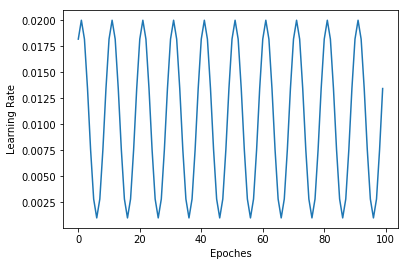

In [466]:
plot_sheduler(torch.optim.lr_scheduler.CosineAnnealingLR(torch.optim.Adam(model.parameters(), lr=0.02), 5, 0.001, -1))

In [103]:
%pdb

Automatic pdb calling has been turned ON


## Evaluate Test

In [334]:
cat_mapped_test, num_mapped_test = mapper.apply(test_processed)
cat_mapped_test, num_mapped_test = torch.tensor(cat_mapped_test, dtype=torch.long), torch.Tensor(num_mapped_test)

D:\dev\libs\Anaconda3\envs\tf140p35\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [335]:
test_processed.shape

(41088, 47)

In [347]:
def create_submission(cat_mapped, num_mapped, model, file_name, device=torch.device('cuda')):
    loader = generate_loader([cat_mapped, num_mapped], 512, shuffle=False)
    use_numeric = len(num_mapped) > 0
    result = np.zeros(len(cat_mapped), dtype=np.int64)
    last_idx = 0
    with torch.no_grad():
        for data in tqdm(loader):
            if use_numeric:
                cat_x, num_x = data
                cat_x, num_x = cat_x.to(device), num_x.to(device)
            else:
                cat_x, = data
                cat_x = cat_x.to(device)
                num_x = None
            pred = model(cat_x, num_x)
            result[last_idx:last_idx+len(cat_x)] = np.maximum(0, np.round(pred.cpu().numpy() * y_base)).squeeze()
            last_idx += len(cat_x)
    assert last_idx == len(cat_mapped)
    df = pd.DataFrame.from_items([('Id', np.arange(1, len(result)+1)), ('Sales', result)] )
    df.to_csv(file_name, index=False)
create_submission(cat_mapped_test, num_mapped_test, model, 'ross_man_submission.csv')

D:\dev\libs\Anaconda3\envs\tf140p35\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
